## Import Statement

In [66]:
from pyspark.sql import SQLContext
from handyspark import *
from pyspark.sql import functions as sf
from matplotlib import pyplot as plt

## Read CSV into Dataframe

In [54]:
# sql_context = SQLContext(sc)
headerRdd=sc.textFile("/home/darkmatter/Desktop/household_power_consumption.txt").map(lambda x:x.split(";")).take(1)[0]
df=sc.textFile("/home/darkmatter/Desktop/household_power_consumption.txt").map(lambda x:x.split(";")).filter(lambda x:x[0]!='Date').toDF(headerRdd)
# df_power = sql_con`text.read.csv(path="/home/darkmatter/Desktop/household_power_consumption.txt",header="true",inferSchema = "true")

In [55]:
df.take(2)

[Row(Date='16/12/2006', Time='17:24:00', Global_active_power='4.216', Global_reactive_power='0.418', Voltage='234.840', Global_intensity='18.400', Sub_metering_1='0.000', Sub_metering_2='1.000', Sub_metering_3='17.000'),
 Row(Date='16/12/2006', Time='17:25:00', Global_active_power='5.360', Global_reactive_power='0.436', Voltage='233.630', Global_intensity='23.000', Sub_metering_1='0.000', Sub_metering_2='1.000', Sub_metering_3='16.000')]

## converting to HandySpark dataframe

In [56]:
handy_df_power = df.toHandy()
handy_df_power

HandyFrame[Date: string, Time: string, Global_active_power: string, Global_reactive_power: string, Voltage: string, Global_intensity: string, Sub_metering_1: string, Sub_metering_2: string, Sub_metering_3: string]

In [57]:
handy_df_power.cols['Date'][:5]

0    16/12/2006
1    16/12/2006
2    16/12/2006
3    16/12/2006
4    16/12/2006
Name: Date, dtype: object

In [58]:
handy_df_power.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Global_active_power: string (nullable = true)
 |-- Global_reactive_power: string (nullable = true)
 |-- Voltage: string (nullable = true)
 |-- Global_intensity: string (nullable = true)
 |-- Sub_metering_1: string (nullable = true)
 |-- Sub_metering_2: string (nullable = true)
 |-- Sub_metering_3: string (nullable = true)



In [59]:
cols_to_use = ["Date","Time","Global_active_power"]
df_power = handy_df_power[cols_to_use]

In [60]:
df_power.cols['Date'][:5]

0    16/12/2006
1    16/12/2006
2    16/12/2006
3    16/12/2006
4    16/12/2006
Name: Date, dtype: object

In [61]:
df_power.isnull(ratio=True)

Date                   0.0
Time                   0.0
Global_active_power    0.0
Name: missing(ratio), dtype: float64

In [62]:
df = df_power.withColumn('DateTime',sf.concat(sf.col('Date'),sf.lit(' '), sf.col('Time')))

In [63]:
df.show(5)

+----------+--------+-------------------+-------------------+
|      Date|    Time|Global_active_power|           DateTime|
+----------+--------+-------------------+-------------------+
|16/12/2006|17:24:00|              4.216|16/12/2006_17:24:00|
|16/12/2006|17:25:00|              5.360|16/12/2006_17:25:00|
|16/12/2006|17:26:00|              5.374|16/12/2006_17:26:00|
|16/12/2006|17:27:00|              5.388|16/12/2006_17:27:00|
|16/12/2006|17:28:00|              3.666|16/12/2006_17:28:00|
+----------+--------+-------------------+-------------------+
only showing top 5 rows



In [64]:
df = df.drop('Date')
df = df.drop('Time')

In [65]:
df.head()

Row(Global_active_power='4.216', DateTime='16/12/2006_17:24:00')

In [82]:
df.cols[:][:5]
df.printSchema()

root
 |-- Global_active_power: string (nullable = true)
 |-- DateTime: string (nullable = true)



TypeError: HandyColumns[DateTime] is not a string

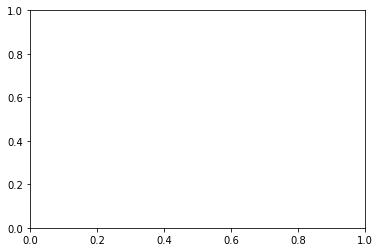

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df.cols['DateTime'],df.cols['Global_active_power'])

In [127]:

%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')

data_path =  "/home/darkmatter/Desktop/household_power_consumption.txt"
cols_to_use = ['Date', 'Time','Global_active_power']

df_uci = pd.read_csv(data_path, sep=';', usecols=cols_to_use)

df_uci['datetime'] = pd.to_datetime(df_uci['Date'] + ' '+ df_uci['Time'])
df_uci = df_uci.drop(['Date','Time'], axis=1)
df_uci = df_uci.set_index('datetime')

/home/darkmatter/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [129]:
import numpy as np
df_uci = df_uci.replace('?', np.nan)
df_uci = df_uci.astype(np.float).fillna(method='bfill')

# For simplication,
# I will resample so that each row
# represents a whole hour
df_uci.head()

,Global_active_power
datetime,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


In [132]:
df_uci_hourly = df_uci.resample('H').sum()
df_uci_hourly['hour'] = df_uci_hourly.index.hour
df_uci_hourly.index = df_uci_hourly.index.date
df_uci_hourly.head()

,Global_active_power,hour
2006-12-16,152.024,17
2006-12-16,217.932,18
2006-12-16,204.014,19
2006-12-16,196.114,20
2006-12-16,183.388,21


In [141]:
df_uci_pivot = df_uci_hourly.pivot(columns='hour')
df_uci_pivot = df_uci_pivot.dropna()
df_ucii_pivot = df_uci_pivot.head(1)
df_ucii_pivot

Global_active_power                                             \
hour                        0        1       2       3        4        5    
2006-12-17             112.948  200.964  95.236  99.732  132.946  119.804   

                                              ...                             \
hour            6       7        8        9   ...       14       15       16   
2006-12-17  78.198  97.202  113.434  152.944  ...  125.558  179.124  199.562   

                                                                       
hour             17       18       19      20       21     22      23  
2006-12-17  204.406  221.826  174.504  201.69  182.446  91.08  26.264  

[1 rows x 24 columns]

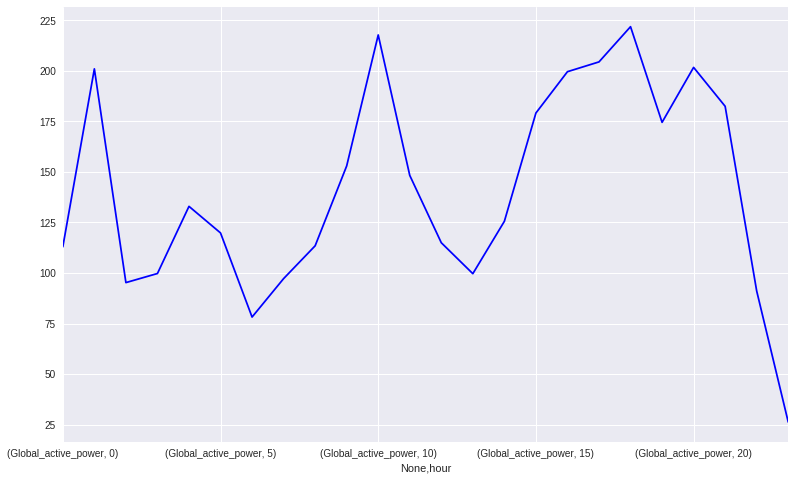

In [142]:
df_ucii_pivot.T.plot(figsize=(13,8), legend=False, color='blue')